In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR

Current venv: C:\Users\LukasGrahl\Documents\GIT\memoire1\env_macro_rbc
DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [5]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

import os
import time

from filterpy.kalman import KalmanFilter
from filterpy.common import Saver

from src.plotting import plot_dfs
from src.process_data import load_data
from src.filtering_sampling import set_up_kalman_filter, kalman_filter, sample_from_priors, solve_updated_mod, get_arr_pdf_from_dist, kalman_filter_forecast
from src.utils import get_most_recent_mod_output

from config import plt_config
plt.rcParams.update(plt_config)

load & solve model

In [ ]:
from config import mod4_params, mod4_priors, mod5_params, mod5_priors, mod6_params, mod6_priors
mods = {
    # 'mod4_rbc_vanilla': {'params': mod4_params,
    #                      'priors': mod4_priors,
    #                      'is_lin': False},
    'mod5_nk_vanilla': {'params': mod5_params,
                        'priors': mod5_priors,
                            'plot_vars': ['A', 'Y', 'C', 'I', 'L', 'w', 'r', 'lambda'],
                        'is_lin': False},    
    'mod6_nk_energy_lin2': {'params': mod6_params,
                                   'is_lin': True,
                                   'priors': mod6_priors,
                        'plot_vars': ['S', 'Y', 'C']},
}

# load model
for key in mods.keys():
    # load
    mods[key]['mod'] = gEconModel(os.path.join(MODEL_DIR, f'{key}.gcn'), verbose=False)
    
    # solve
    _, mods[key]['mod'] = solve_updated_mod(mods[key]['mod'], verbose=True, model_is_linear=mods[key]['is_lin'])
    assert _ == True
    
    # get shocks
    mods[key]['shocks'] = [item.base_name for item in mods[key]['mod'].shocks]
    
    # load posterior estimates
    file_name = get_most_recent_mod_output(POST_EST_DIR, f'{key}_accepted')
    print(file_name)
    mods[key]['post_out'] = xr.open_dataset(os.path.join(POST_EST_DIR, file_name))

#### choose model for futher analysis

In [11]:
name = 'mod6_nk_energy_lin2'
xarr = mods[name]['post_out']
mod = mods[name]['mod']
prior_dist = mods[name]['priors']
plot_vars = mods[name]['plot_vars']
mod_params = mods[name]['params']
mod_is_linear = mods[name]['is_lin']

In [9]:
file_path = os.path.join(POST_EST_DIR, 'mod6_nk_energy_lin2_accepted_20230426_1326.nc')
xarr_acc.to_netcdf(file_path)


In [13]:
mod.free_param_dict

{'M': 3.0,
 'X': 0.03,
 'alpha_m': 0.4,
 'alpha_n': 0.4,
 'beta': 0.995,
 'epsilon': 1.0,
 'gamma': 0.1,
 'phi_pi': 1.1,
 'rho_s': 0.9,
 'theta': 0.75}

#### posterior quantiles

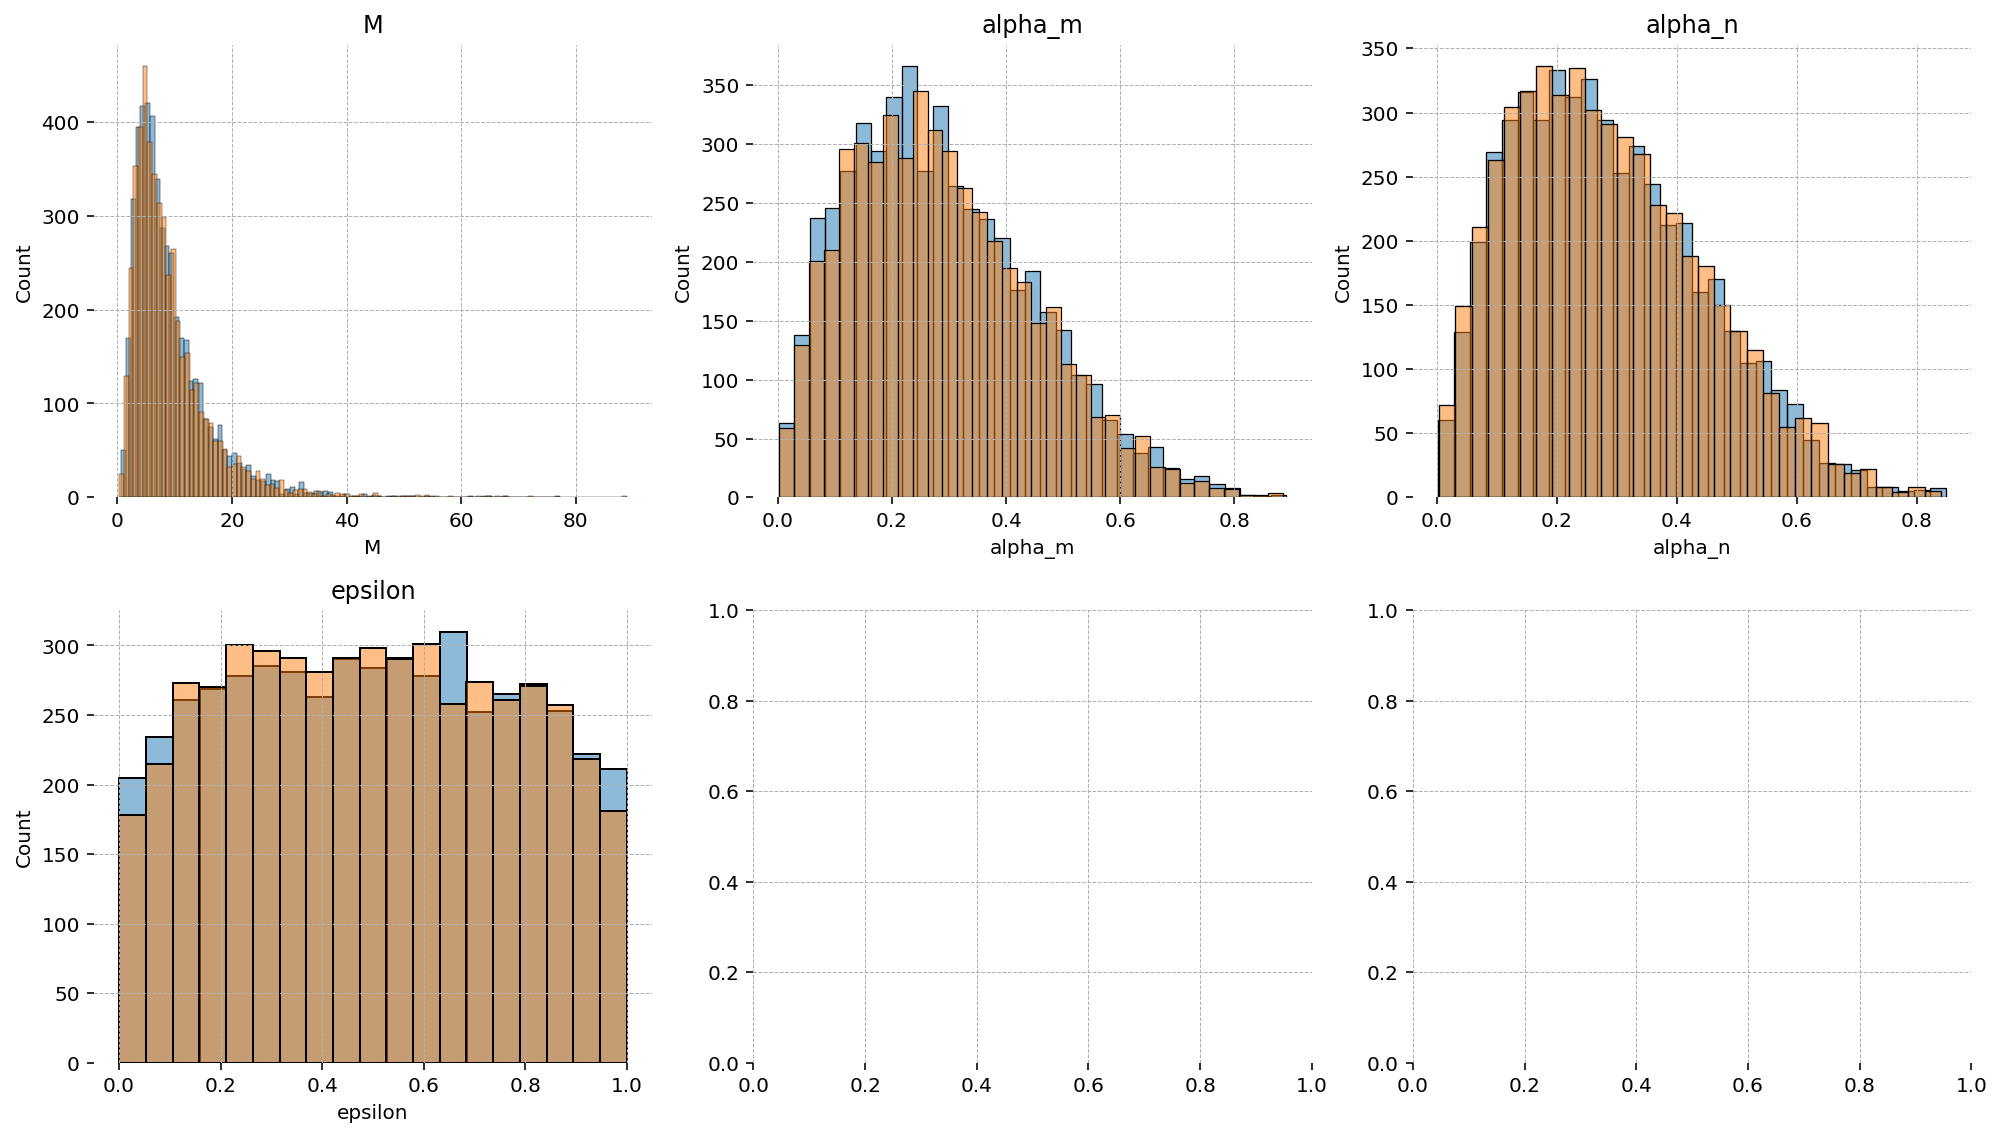

In [14]:
n_runs = xarr.n_runs_acc.values
x1 = pd.DataFrame(xarr.posterior, columns=xarr.parameter)
x2 = pd.DataFrame([[prior_dist[param].rvs() for item in range(0, len(xarr.draw))] for param in xarr.parameter.values],
                  index=xarr.parameter).transpose()
plot_dfs(dfs_data=[x2, x1], plotfunc=sns.histplot, alpha=.5, legend=['prior', 'posterior'])

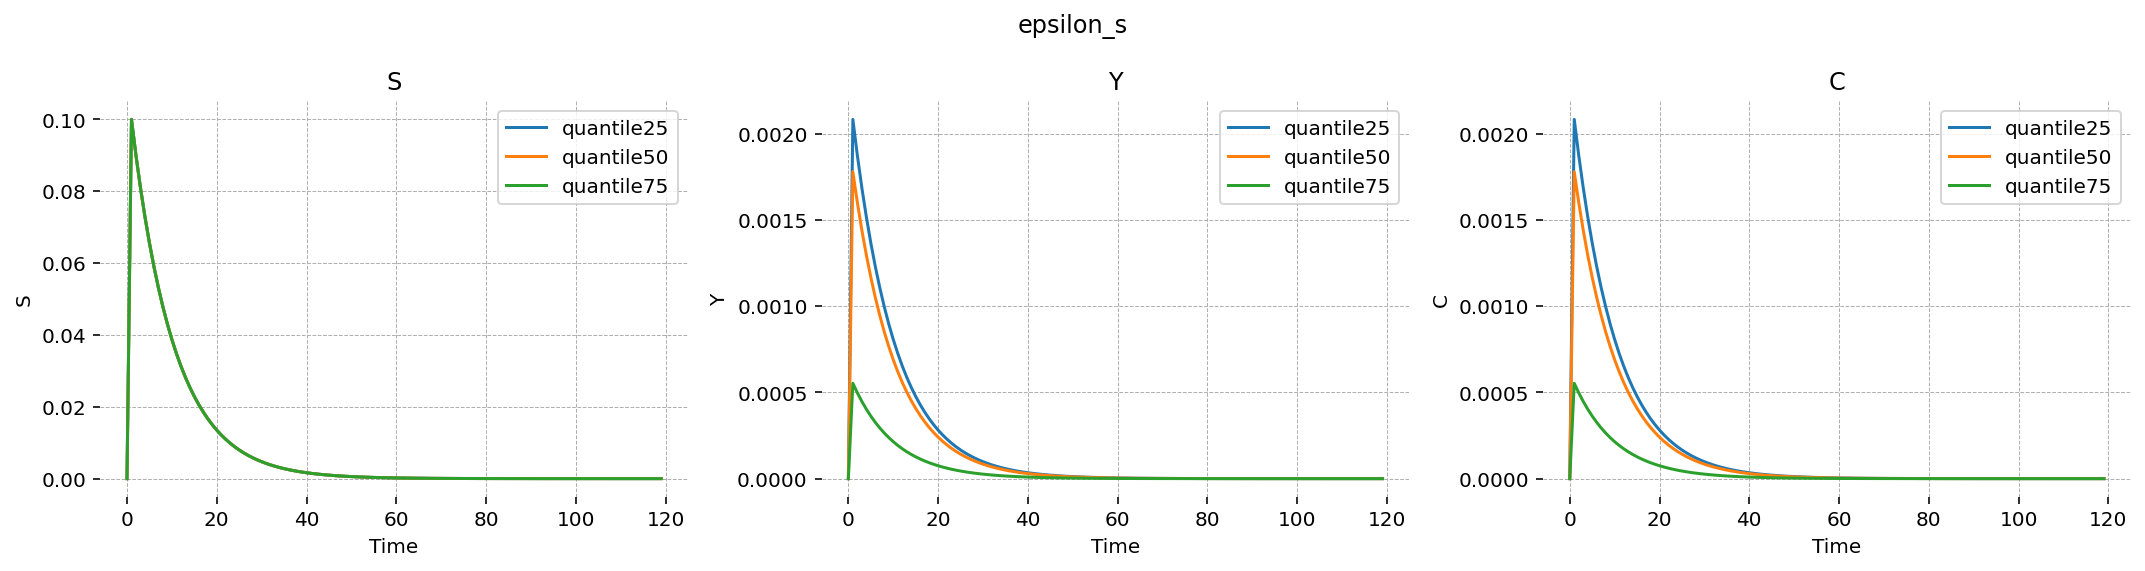

In [15]:
shock_size = .1
sim_length = 120

param_sets = [
    dict(zip(xarr.parameter.values, xarr.posterior_q1.values)),
    dict(zip(xarr.parameter.values, xarr.posterior_q2.values)),
    dict(zip(xarr.parameter.values, xarr.posterior_q3.values))
]

irfs = []
# get irf for each model
for i, params in enumerate(param_sets):
    mod.free_param_dict.update(params)
    _, mod = solve_updated_mod(mod, verbose=False, model_is_linear=mod_is_linear)
    assert _ == True
    irfs.append(mod.impulse_response_function(simulation_length=sim_length, shock_size=shock_size))
    mod.free_param_dict.update(mod_params)
    

# set plotting shock
shock = 'epsilon_s'
for i, irf in enumerate(irfs):
    irfs[i] = irf.unstack().loc[:, shock].unstack().copy()

# plot shocks
plot_dfs([df[mods[name]['plot_vars']] for df in irfs],
         sns.lineplot,
         fig_title=shock,
         figsize=(15, 4),
         legend=['quantile' + str(x) for x in [25, 50, 75]]
        )